In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import numpy.ma as ma
import scipy.stats

from hist import Hist

import matplotlib
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=8)

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

## Shear map from a movable Single Isothermal Sphere.

In [3]:
xvalues = np.arange(0, 1., 0.04)
yvalues = np.arange(0, 1., 0.04)
xx, yy = np.meshgrid(xvalues, yvalues)

# Location of sphere
center = (0.5, 0.5)

Calculate the shear field from a singlular isothermal sphere with lensing potential

$$ \Psi = c\sqrt{x^2 + y^2} $$

with 

$$ \kappa = \frac{c}{2R} , \qquad \gamma_1 = c \frac{(y^2 - x^2)}{2R^3}, \qquad \gamma_2 = -\frac{cxy}{R^3} $$

where $ R = \sqrt{x^2 + y^2}$

In [4]:
c = 0.07

x = xx - center[0]
y = yy - center[1]

R = np.sqrt(x**2 + y**2)
kappa = c/(2*R)
gamma1 = c*(y**2 - x**2)/(2*R**3)
gamma2 = -c*(x*y)/R**3

g1 = gamma1/(1 - kappa)
g2 = gamma2/(1 - kappa)

# Calculate reduced shear
reduced_shear = g1 + g2*1j
magnitude = np.abs(reduced_shear)
phi = np.angle(reduced_shear)/2

## Explore the distribution of g1 and g2

/Users/walter/.conda/envs/dask/lib/python3.9/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


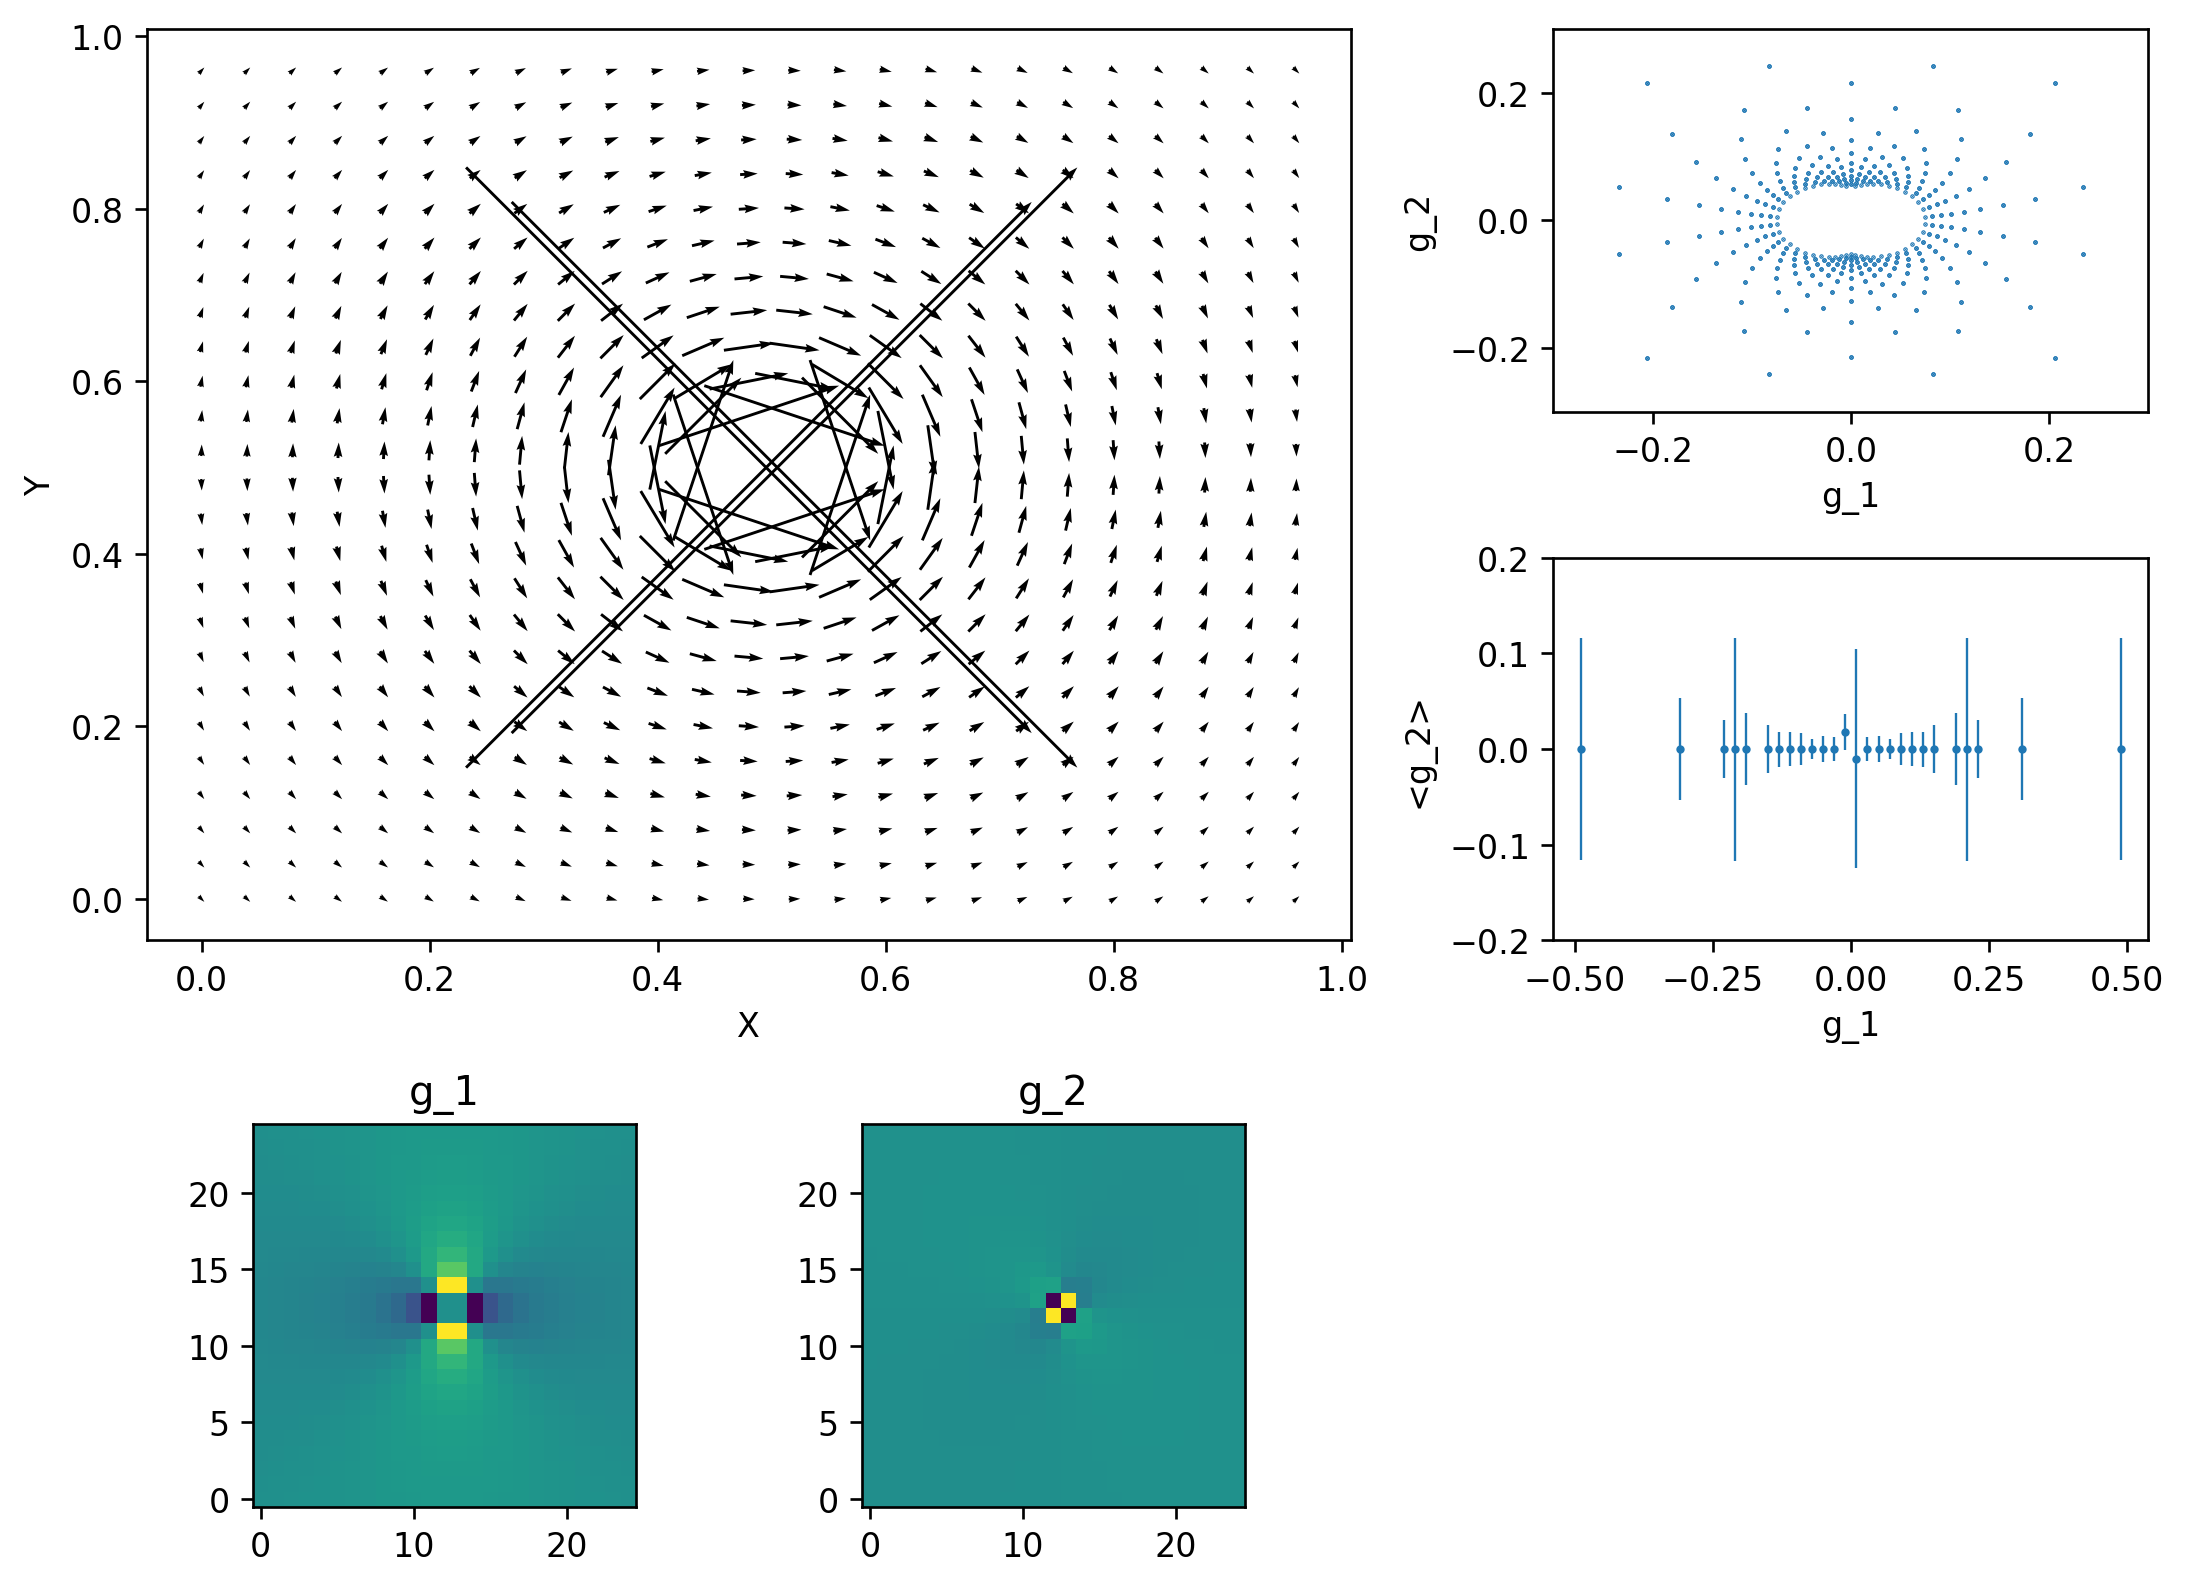

In [5]:
#%%script false --no-raise-error

# Make profile histogram

h = Hist.new.Reg(50, -.5, .5).Mean()
h.fill(g1.flatten(), sample=g2.flatten())

centers = h.axes.centers[0]
mean = h.view().value

with np.errstate(invalid='ignore'):
    error_on_mean = np.sqrt(h.view().variance/h.view().count) 
    
mean_masked = ma.masked_where(h.view().count <= 2, mean)

# Make the plots

# Canvas Setup
fig = plt.figure(figsize=(9, 6.5), constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[0:2, 0:2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1,2])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

# Plots
ax0.quiver(xx, yy, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')

ax1.scatter(g1, g2, marker='.', s=.5)
ax1.set_xlabel('g_1')
ax1.set_ylabel('g_2')
ax1.set_xlim(-.3, .3)
ax1.set_ylim(-.3, .3)

ax2.errorbar(x=centers, y=mean_masked, yerr=error_on_mean, fmt = '.', markersize=3, elinewidth=.7)
ax2.set_xlabel('g_1')
ax2.set_ylabel('<g_2>')
ax1.set_xlim(-.3, .3)
ax2.set_ylim(-.2, .2)

ax3.imshow(g1, origin='lower')
ax4.imshow(g2, origin='lower')
ax3.set_title('g_1');
ax4.set_title('g_2');

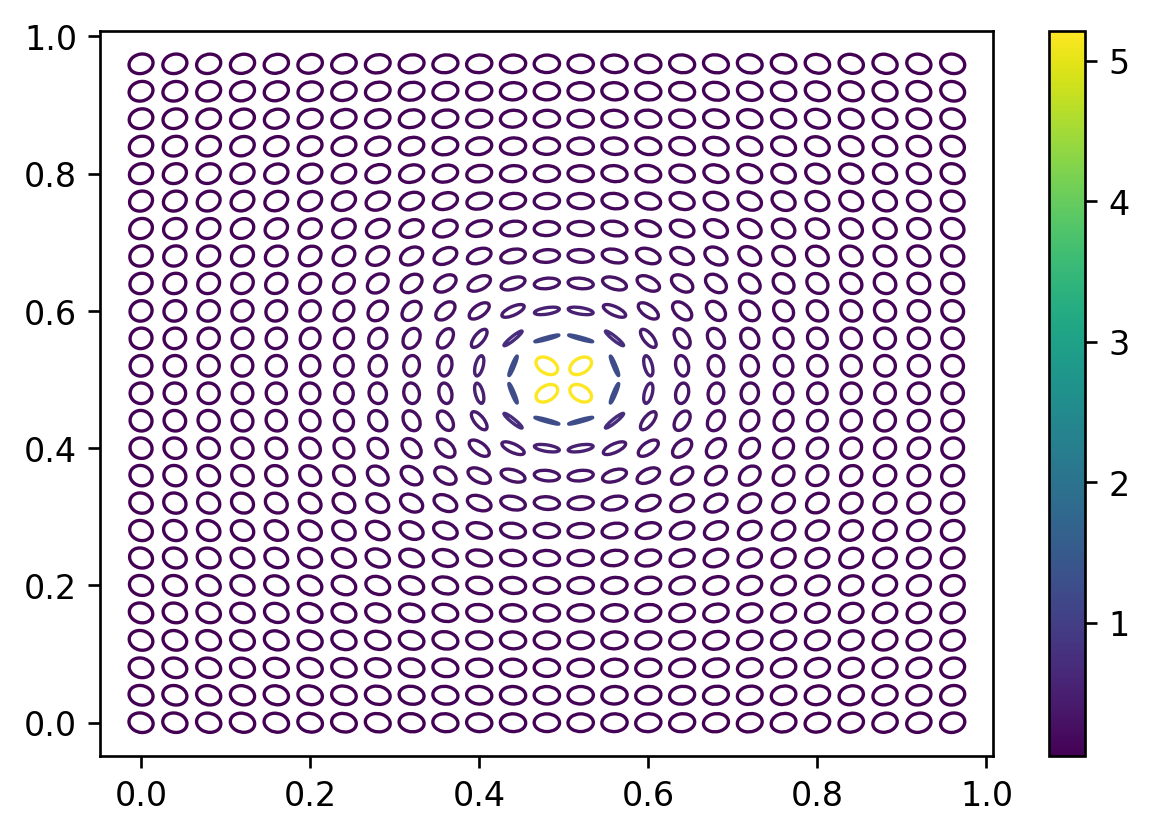

In [6]:
from matplotlib.collections import EllipseCollection

fig, ax = plt.subplots()

unit_vector = np.full(g1.shape, .03)
position = np.column_stack((xx.ravel(), yy.ravel()))
r = (1-abs(magnitude))/(1+abs(magnitude))

ellipses = EllipseCollection(unit_vector, r*unit_vector, (phi)*180/np.pi, units='xy', offsets=position, transOffset=ax.transData, 
                             facecolors='None')
ellipses.set_array(abs(magnitude).ravel())
ax.add_collection(ellipses)

ax.autoscale_view()
plt.colorbar(ellipses)

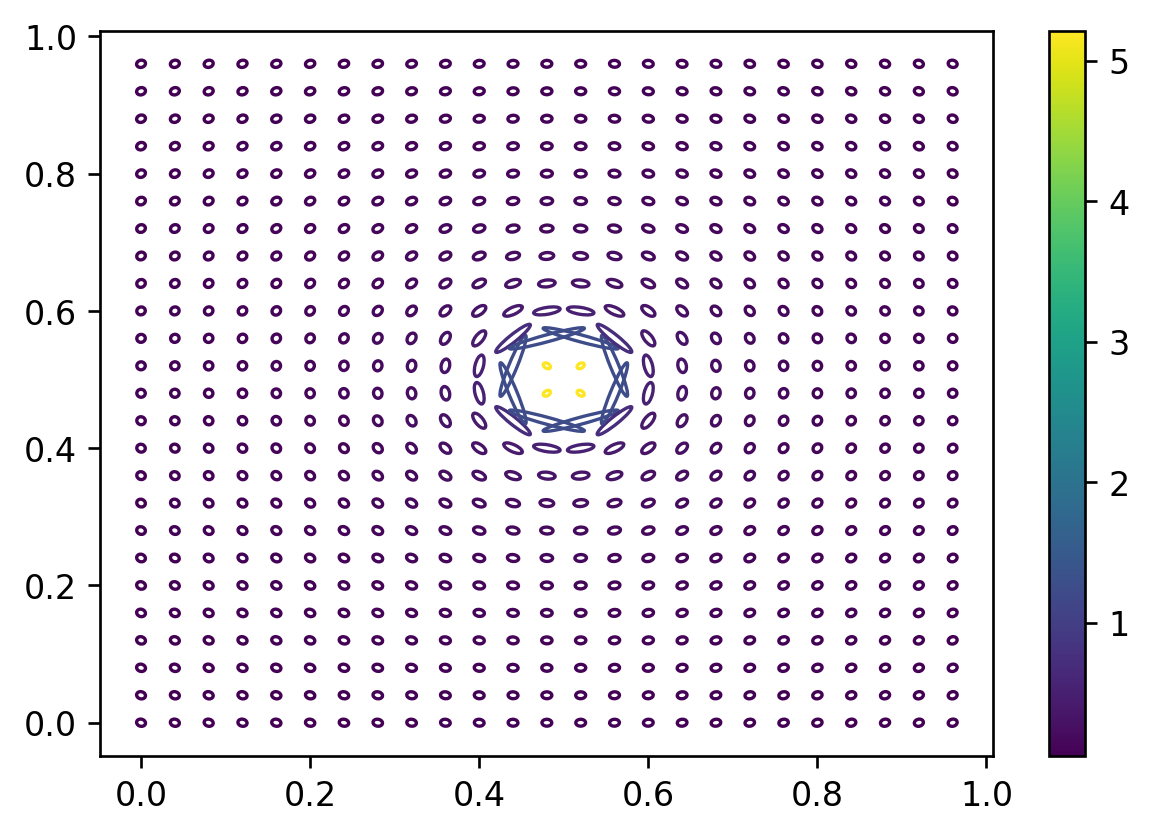

In [7]:
from matplotlib.collections import EllipseCollection

fig, ax = plt.subplots()

unit_vector = np.full(g1.shape, 0.01)
position = np.column_stack((xx.ravel(), yy.ravel()))
major_sheared = unit_vector/((1-kappa)*(1-abs(magnitude)))
minor_sheared = unit_vector/((1-kappa)*(1+abs(magnitude)))

ellipses = EllipseCollection(major_sheared, minor_sheared, (phi)*180/3.14, units='xy', offsets=position, transOffset=ax.transData, 
                             facecolors='None')
ellipses.set_array(abs(magnitude).ravel())
ax.add_collection(ellipses)

ax.autoscale_view()
plt.colorbar(ellipses)

(-2.0, 2.0)

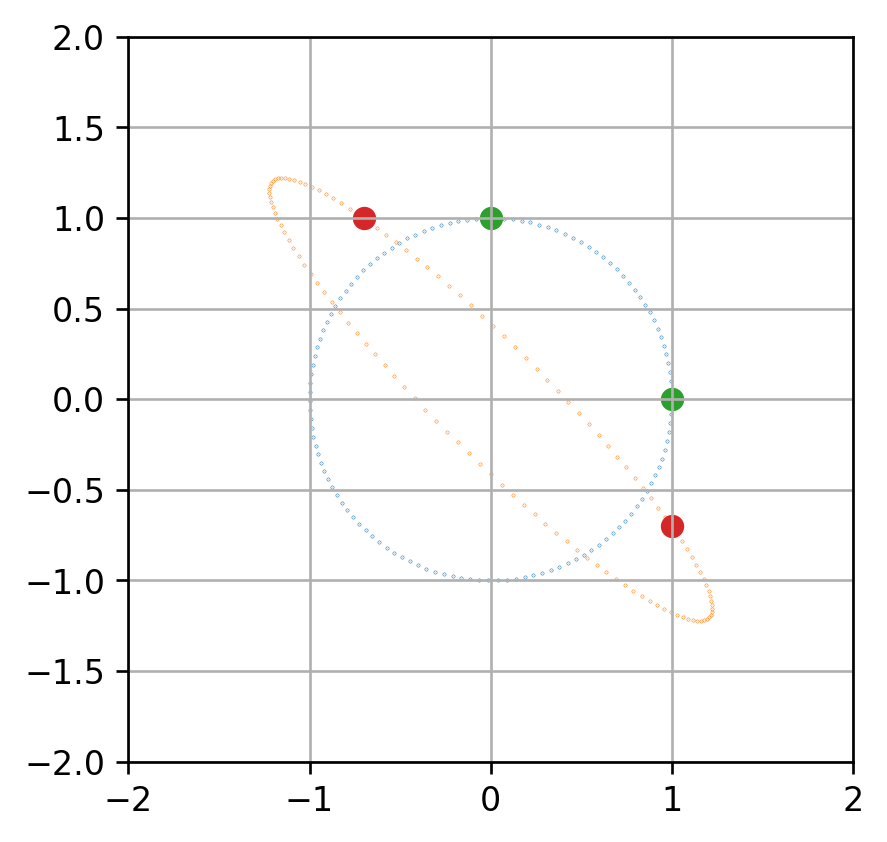

In [8]:
#with np.errstate(invalid='ignore', divide='ignore'):
#    norm = np.sqrt(1-magnitude**2)
#    shear_matrices = np.dstack([1+g1, g2, g2, 1-g1]/norm).reshape(*g1.shape, 2, 2)

shear = np.array([[ 1., -0.70206669], [-.70206669,  1.]])
points = np.array([[1,0], [0,1]])

circle = [(np.cos(theta), np.sin(theta)) for theta in np.arange(0, 2*np.pi, .05)]
circle = np.array(circle)

transformed = np.einsum('ij,lj->li', shear, points)
transformed_circle = np.einsum('ij,lj->li', shear, circle)

plt.scatter(x=circle[:,0], y=circle[:,1], marker='.', s=.1)
plt.scatter(x=transformed_circle[:,0], y=transformed_circle[:,1], marker='.', s=.1)
plt.scatter(x=points[0], y=points[1])
plt.scatter(x=transformed[0], y=transformed[1])

plt.gca().set_aspect('equal')
plt.grid(True)
plt.xlim(-2,2)
plt.ylim(-2,2)

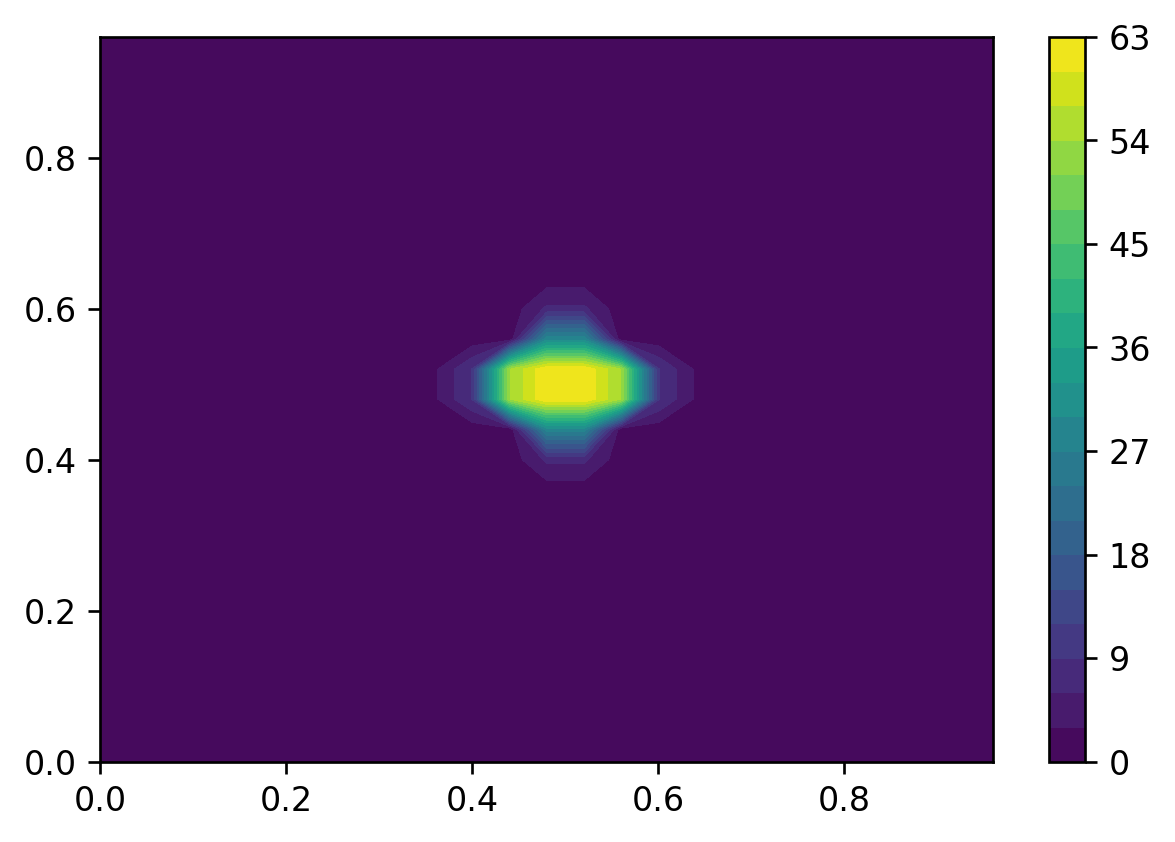

In [9]:
def calculate_curl(u, v,spacing_x, spacing_y):
    dFy_dx = np.gradient(v, spacing_x, axis=[1])
    dFx_dy = np.gradient(u, spacing_y, axis=[0])
    
    curl = dFy_dx - dFx_dy
    return curl

spacing_x = xvalues[1] - xvalues[0]
spacing_y = yvalues[1] - yvalues[0]

curl = calculate_curl(magnitude*np.cos(phi), magnitude*np.sin(phi), spacing_x, spacing_y)
plt.contourf(xvalues, yvalues, abs(curl), levels=20)
plt.colorbar()